In [1]:
import torch
import numpy as np
from sbi.inference import prepare_for_sbi, SNLE, SNPE
from sbi.simulators.linear_gaussian import diagonal_linear_gaussian
import sbi.utils as sbi_utils

pyknos/nflows/nn/nde


### Load theta and x

In [2]:
data = np.load('../results/cleaned_up_data_onlyNumSpikes_calibrationKernel.npz', allow_pickle=True)

x = torch.as_tensor(data['data'], dtype=torch.float32)
theta = torch.as_tensor(data['params'], dtype=torch.float32)

In [3]:
x = x[:, :1]

In [4]:
x.shape

torch.Size([728700, 1])

In [5]:
import sys
sys.path.append('../')

In [6]:
from parameter_setup import load_ground_truth_params, load_prior_min, load_prior_max

### Load data to standardize - needed to standardize x_o

In [7]:
#standardize_vals = np.load('../results/standardize_vals.npz')
#x_mean = standardize_vals['data_mean']
#x_std = standardize_vals['data_std']
#
#theta_mean = standardize_vals['theta_mean']
#theta_std = standardize_vals['theta_std']

x_mean = x.mean(dim=0)
x_std = x.std(dim=0)

theta_mean = theta.mean(dim=0)
theta_std = theta.std(dim=0)

In [8]:
x = (x-x_mean) / x_std
theta = (theta-theta_mean) / theta_std

### Load x_o (which I got from running the simulator with Arco's ground truth params)

In [9]:
import numpy as np
x_o = torch.as_tensor(np.load('../results/observation/x_o_new_ss.npz')['x_o'], dtype=torch.float32)
print(x_o)
x_o = x_o[:1]
x_o = (x_o - x_mean) / x_std
x_o = x_o.unsqueeze(0)

tensor([ 3.0000e+00, -7.3972e+01,  3.1537e-03, -7.0379e+01,  2.5909e+02,
         2.7430e+00,  1.3598e+01,  1.0000e+00, -7.0373e+01,  2.5281e-03,
        -5.4636e+01,  9.4801e+02,  7.5035e-01,  1.9276e+00,  1.0000e+00,
        -7.3972e+01,  3.1537e-03, -7.3567e+01,  2.9432e+01,  1.0631e+01,
         1.5560e+02,  0.0000e+00, -7.0373e+01,  2.5281e-03, -6.9793e+01,
         2.8696e+01,  4.8228e+00,  2.8244e+01,  1.0000e+00, -6.8981e+01,
         2.4896e-03, -6.8497e+01,  2.7113e+01,  4.6703e+00,  2.6055e+01])


In [10]:
x_o

tensor([[5.0126]])

### Create dummy simulator and dummy prior

In [11]:
def dummy_simulator(theta):
    return torch.ones(1,1)

dummy_prior = sbi_utils.BoxUniform(torch.as_tensor(load_prior_min()), torch.as_tensor(load_prior_max()))
_bound = torch.sqrt(torch.as_tensor(3.))
dummy_prior_norm = sbi_utils.BoxUniform(-_bound*torch.ones(35), _bound*torch.ones(35))

In [12]:
from sbi.utils.get_nn_models import likelihood_nn, posterior_nn

In [13]:
simulator, prior, x_shape = prepare_for_sbi(dummy_simulator, dummy_prior_norm)

#nsf = likelihood_nn(
#    model='nsf',
#    theta_shape=prior.sample().shape,
#    x_o_shape=x_shape,
#    hidden_features=100,
#    flow_num_transforms=10,
#)

nsf_posterior = posterior_nn(
    model='nsf',
    prior=prior,
    x_o_shape=x_shape,
    hidden_features=100,
    flow_num_transforms=10,
)

/home/michael/anaconda3/envs/sbi/lib/python3.8/site-packages/nflows/transforms/standard.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "_shift", torch.tensor(shift if (shift is not None) else 0.0)
/home/michael/anaconda3/envs/sbi/lib/python3.8/site-packages/nflows/transforms/standard.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "_scale", torch.tensor(scale if (scale is not None) else 1.0)


In [14]:
x

tensor([[-0.4203],
        [-0.4203],
        [-0.4203],
        ...,
        [-0.4203],
        [-0.4203],
        [ 2.2962]])

In [15]:
x_shape

torch.Size([1])

In [17]:
inference = SNPE(
    simulator, 
    prior,
    x_shape,
    external_data=(theta, x), # todo: remove the [:1000] to train on all datasamples
    mcmc_method='slice', 
    density_estimator=nsf_posterior
)

In [18]:
posterior = inference(
    num_rounds=1,
    num_simulations_per_round=0,
    batch_size=100, # default is 50
    stop_after_epochs=5, # default is 20
)

Neural network successfully converged after 17 epochs.


In [19]:
import pickle
with open('../results/posteriors/200630_PosteriorSNPE_onlyBurst.pickle', 'wb') as handle:
    pickle.dump(posterior, handle)

### Run VI

In [22]:
from sbi.utils.get_nn_models import get_vi_net
from sbi.utils.vi import train_vi, train_mle
import torch
import sbi.utils as utils

In [23]:
import sys
sys.path.append('../../../bFlows')
from bflows.utils.neural_net.get_bounded_flows import get_bflow

In [24]:
vi_net = get_vi_net(parameter_dim=35)

# Temper the posterior

In [38]:
import numpy as np
x_o = torch.as_tensor(np.load('../results/observation/x_o_new_ss.npz')['x_o'], dtype=torch.float32)
x_o = x_o[:1]
x_o[0] = 2.

In [39]:
x_o = (x_o - x_mean) / x_std
#x_o = x_o.unsqueeze(0)

In [40]:
x_o

tensor([2.2962])

# Train the VI

In [41]:
posterior = posterior.set_default_x(x_o)

AssertionError: Observed data shape (torch.Size([1, 1])) must match the shape of simulated data x (torch.Size([1])).

In [29]:
vi_net_ = get_bflow('nsf_uncond_bounded', prior=prior, context=x_o, num_coupling=10, hidden_features=200)
trained_vi_net = train_vi(vi_net_, posterior, batch_size=500, stop_after_epochs=50)

/home/michael/Documents/sbi/sbi/inference/posterior.py:247: UserWarning: The log probability from SNL is only correct up to a normalizing constant.
  warn(


loss:    tensor(-14.2404, grad_fn=<MeanBackward0>)
loss:    tensor(-14.4094, grad_fn=<MeanBackward0>)
loss:    tensor(-16.4963, grad_fn=<MeanBackward0>)
loss:    tensor(-16.4763, grad_fn=<MeanBackward0>)
loss:    tensor(-16.6338, grad_fn=<MeanBackward0>)
loss:    tensor(-17.8953, grad_fn=<MeanBackward0>)
loss:    tensor(-18.9877, grad_fn=<MeanBackward0>)
loss:    tensor(-20.0535, grad_fn=<MeanBackward0>)
loss:    tensor(-21.3349, grad_fn=<MeanBackward0>)
loss:    tensor(-22.1420, grad_fn=<MeanBackward0>)
loss:    tensor(-23.1822, grad_fn=<MeanBackward0>)
loss:    tensor(-23.6044, grad_fn=<MeanBackward0>)
loss:    tensor(-23.6771, grad_fn=<MeanBackward0>)
loss:    tensor(-22.7450, grad_fn=<MeanBackward0>)
loss:    tensor(-23.1938, grad_fn=<MeanBackward0>)
loss:    tensor(-22.0302, grad_fn=<MeanBackward0>)
loss:    tensor(-23.3385, grad_fn=<MeanBackward0>)
loss:    tensor(-23.1001, grad_fn=<MeanBackward0>)
loss:    tensor(-24.5272, grad_fn=<MeanBackward0>)
loss:    tensor(-24.6427, grad_

In [30]:
import pickle
with open('../results/posteriors/200622_PosteriorSNL_VI_NumSpikes_calibrated.pickle', 'wb') as handle:
    pickle.dump(trained_vi_net, handle)

### Analyse posterior

In [31]:
import pickle
with open('../results/posteriors/200623_PosteriorSNL_NumSpikes_calibration.pickle', 'rb') as handle:
    posterior = pickle.load(handle)

In [32]:
import pickle
with open('../results/posteriors/200622_PosteriorSNL_VI_NumSpikes_calibrated.pickle', 'rb') as handle:
    trained_vi_net = pickle.load(handle)

In [33]:
s = []
num_iter = 10
num_samples_per_iter = 1000

for k in range(num_iter):
    print("new iter,", k)
    samples = trained_vi_net.sample(num_samples_per_iter).detach()

    # denormalize the samples
    samples = samples * theta_std + theta_mean

    # convert to list for pickling
    samples_list = samples.numpy().tolist()
    
    s.append(samples_list)
s = np.asarray(s)
s = s.reshape(num_iter*num_samples_per_iter, -1)

new iter, 0
new iter, 1
new iter, 2
new iter, 3
new iter, 4
new iter, 5
new iter, 6
new iter, 7
new iter, 8
new iter, 9


In [34]:
s_list = s.tolist()

In [35]:
print(s_list[0])

[138.39794921875, 0.02207452617585659, 191.3704833984375, 0.00734819658100605, 167.87359619140625, 0.02498830109834671, 0.0015383628197014332, 0.0009792555356398225, 5.1614217227324843e-05, 0.15563201904296875, 0.005237556528300047, 0.006436765193939209, 0.0005208734073676169, 0.6840335130691528, 0.22224026918411255, 0.08310504257678986, 0.09946738183498383, 0.018469423055648804, 2.5847198963165283, 1.9917058944702148, 0.006798768416047096, 0.0031093622092157602, 0.004890249110758305, 0.009707055985927582, 0.07212281227111816, 0.03332272171974182, 0.12162593007087708, -1.772070050239563, 1.5487139225006104, 0.3148680329322815, 9.596590825822204e-05, 3.699894296005368e-05, 7.657681271666661e-05, 4.940806684317067e-05, 0.8023563623428345]


In [44]:
with open('../results/samples/200629_PosteriorSNL_NumSpikesCalibrated_VI_samples.pickle', 'wb') as handle:
    pickle.dump(s_list, handle, protocol=2)

In [37]:
gt_params = [137.862136034238,
 0.0005793520824526776,
 199.1298048149789,
 0.0006108049075983062,
 152.1647419393015,
 0.00742430653684668,
 0.0010965218089651857,
 0.0008186770602065786,
 0.00011435310571497434,
 0.0022763084379226854,
 0.0036986082079423594,
 0.00013883334761566004,
 3.2474860530531394e-06,
 0.005426837416265438,
 0.10568666421909532,
 0.04812676692103998,
 0.094826660872338,
 0.013854989311151315,
 3.9010342040060975,
 3.8851157748263354,
 0.009964343408409574,
 0.006000497448875096,
 0.0012602755616811401,
 0.01392240648099882,
 0.06283710421562513,
 6.68382138396179e-05,
 0.08311048073340864,
 -2.9836949894223825,
 1.9642986130169147,
 1.2999358521956366,
 4.4931548434199036e-05,
 2.062212836678345e-05,
 4.22059843297412e-05,
 2.2409802171891654e-05,
 1.7109080877160283]

In [38]:
gt_params_norm = (torch.as_tensor(gt_params) - theta_mean) / theta_std

In [39]:
samples = trained_vi_net.sample(10000).detach()

In [40]:
probs = posterior.log_prob(samples, x=x_o).detach().numpy()
prob_of_gt = posterior.log_prob(gt_params_norm.unsqueeze(0), x=x_o).detach().numpy()

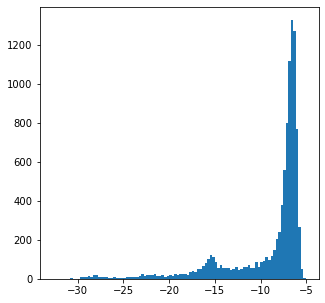

In [42]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1, figsize=(5,5))
_ = plt.hist(probs, bins=100)
ax.axvline(prob_of_gt, color='r')

In [43]:
prob_of_gt

array([-inf], dtype=float32)

In [33]:
dummy_prior_norm.log_prob(gt_params_norm.unsqueeze(0))

tensor([-43.4859])

### Posterior predictives
Has to be done in a different virtual env with python 2.